## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час и построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


# 1. Подготовка

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor, Pool

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.info()
display(data.head())
display(data.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


In [3]:
def make_features(df, max_lag, rolling_mean_size):
    for i in range(1, max_lag + 1):
        df[f'lag_{i}'] = df['num_orders'].shift(i)
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['hour'] = df.index.hour
    return df

## Вывод

Данные загружена, индекс отсортирован по дате, данные приведены к часовому интервалу. 

В нашем распоряжении информация с марта по август 2018 года. 

Приступим к анализу.

# 2. Анализ

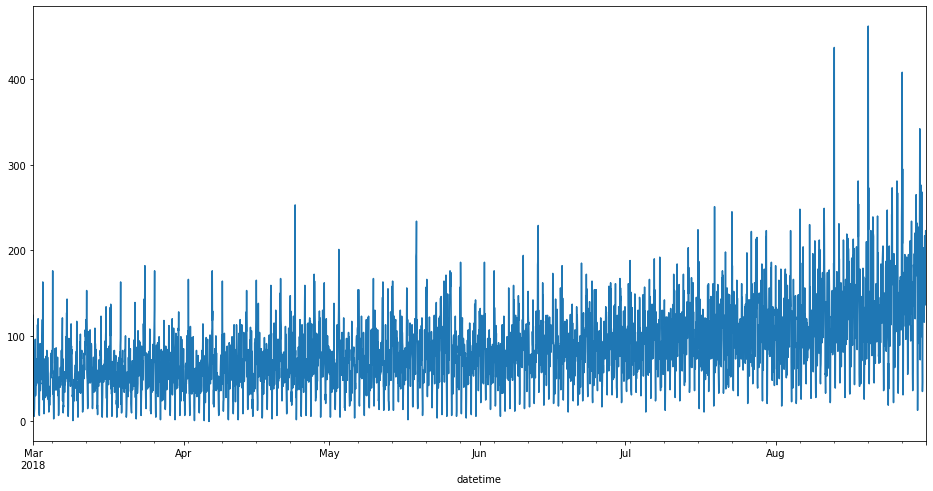

In [4]:
data['num_orders'].plot(kind='line', figsize=(16,8))
plt.show()

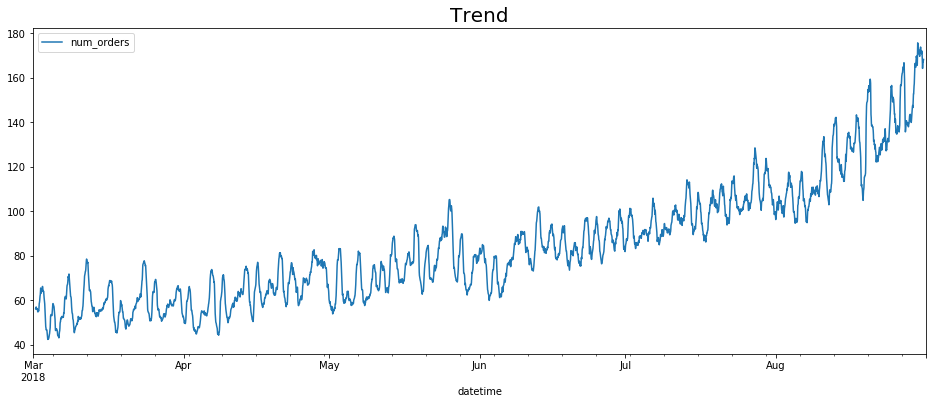

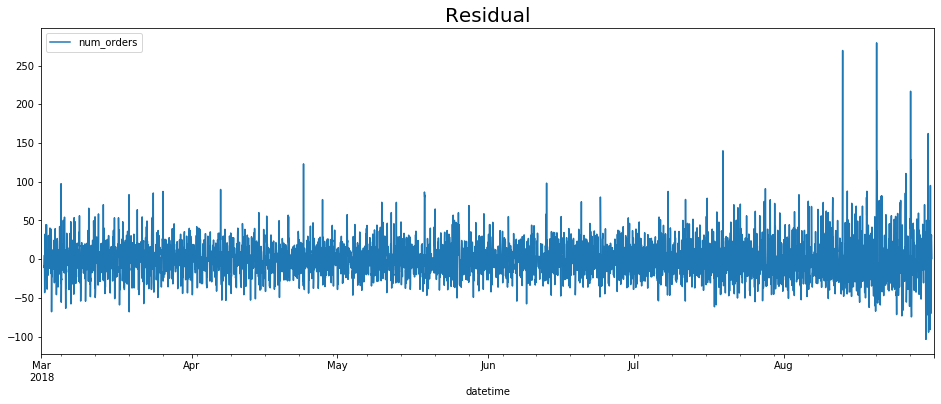

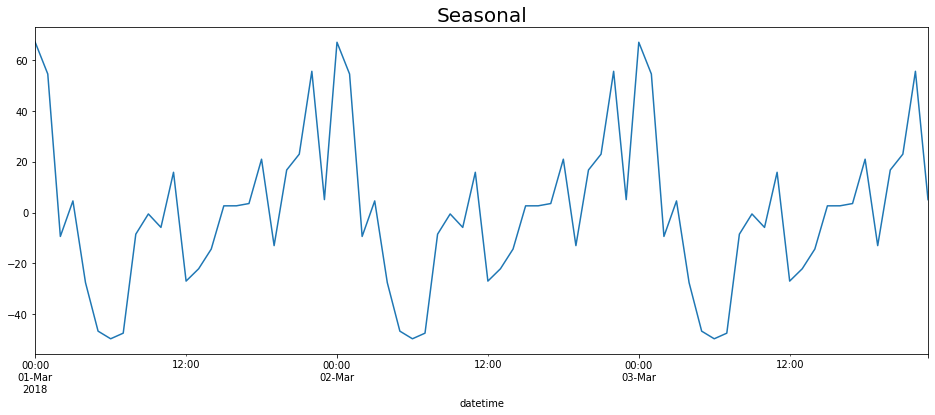

In [5]:
decomposed = seasonal_decompose(data['num_orders'])
trend = decomposed.trend
residual = decomposed.resid
trend.plot(figsize=(16,6))
plt.title('Trend', fontsize=20)
plt.legend()
plt.show()
residual.plot(figsize=(16,6))
plt.title('Residual', fontsize=20)
plt.legend()
plt.show()

decomposed = seasonal_decompose(data['2018-03-01':'2018-03-03']['num_orders'])
seasonal = decomposed.seasonal
seasonal.plot(figsize=(16,6))
plt.title('Seasonal', fontsize=20)
plt.show()

## Вывод
На графике тренда мы видим что количество заказов такси увеличивается от месяца к месяцу и с марта по август количество увеличилось почти в три раза. 

На графике сезонности мы видим что пиковые нагрузки приходятся в районе 12 ночи, а уже к трем часам ночи нагрузка падает до минимальной за сутки.

# 3. Обучение

In [6]:
best = float('inf')
for lag in range(3, 35, 5):
    for roll in range(3, 35, 5):
        print(f'lag - {lag}, roll - {roll}'.center(90, '-'))
        new_data = make_features(data.copy(), lag, roll)
        new_data.dropna(inplace=True)
        
        features, targets = new_data.drop(columns='num_orders'), new_data['num_orders']
        features_train, features_tmp, target_train, target_tmp = train_test_split(
            features, targets, test_size = 0.2, shuffle=False
        )
        features_valid, features_test, target_valid, target_test = train_test_split(
            features_tmp, target_tmp, test_size = 0.5, shuffle=False
        )
        model = LinearRegression()
        model.fit(features_train, target_train)
        predicted = model.predict(features_train)
        rmse = mean_squared_error(target_train, predicted) ** 0.5
        print(f'rmse on train data is - {rmse:.3f}')

        predicted = model.predict(features_valid)
        rmse = mean_squared_error(target_valid, predicted) ** 0.5
        print(f'rmse on valid data is  - {rmse:.3f}')
        if rmse < best:
            best = rmse
            best_lag = lag
            best_roll = roll
print(
    f'Best rmse on valid data was {best:.3f} '
    f'with lag {best_lag} and roll {best_roll}'
)

------------------------------------lag - 3, roll - 3-------------------------------------
rmse on train data is - 29.067
rmse on valid data is  - 40.786
------------------------------------lag - 3, roll - 8-------------------------------------
rmse on train data is - 29.060
rmse on valid data is  - 40.758
------------------------------------lag - 3, roll - 13------------------------------------
rmse on train data is - 29.091
rmse on valid data is  - 40.690
------------------------------------lag - 3, roll - 18------------------------------------
rmse on train data is - 28.984
rmse on valid data is  - 40.801
------------------------------------lag - 3, roll - 23------------------------------------
rmse on train data is - 29.078
rmse on valid data is  - 40.930
------------------------------------lag - 3, roll - 28------------------------------------
rmse on train data is - 29.109
rmse on valid data is  - 40.743
------------------------------------lag - 3, roll - 33----------------------

In [7]:
data = make_features(data, 33, 23)
data.dropna(inplace=True)
features, targets = data.drop(columns='num_orders'), data['num_orders']
features_train, features_tmp, target_train, target_tmp = train_test_split(
            features, targets, test_size = 0.2, shuffle=False
)
features_valid, features_test, target_valid, target_test = train_test_split(
        features_tmp, target_tmp, test_size = 0.5, shuffle=False
)
display(features_train.shape, features_valid.shape, features_test.shape)

(3506, 38)

(438, 38)

(439, 38)

С помощью линейной модели опрелеяем оптимальный набор дополнительных параметров. В нашем случае оптимально брать данные за последние три часа и скользящую среднюю за последние три часа.

In [8]:
model = RandomForestRegressor(random_state=12345, n_estimators=50, max_depth=20)
model.fit(features_train, target_train)
predicted = model.predict(features_train)
rmse = mean_squared_error(target_train, predicted) ** 0.5
print(f'rmse on train data is - {rmse:.3f}')

predicted = model.predict(features_valid)
rmse = mean_squared_error(target_valid, predicted) ** 0.5
print(f'rmse on validation data is  - {rmse:.3f}')

rmse on train data is - 8.328
rmse on validation data is  - 32.845


Случайный лес как и линейная регрессия переобучается на тренировочных данных и показывает не такой хороший  результат на тестовых данных.  Хоть формально наша минимальная цель это rmse 48, и мы ее достигли, попробуем улучшить наши результаты.

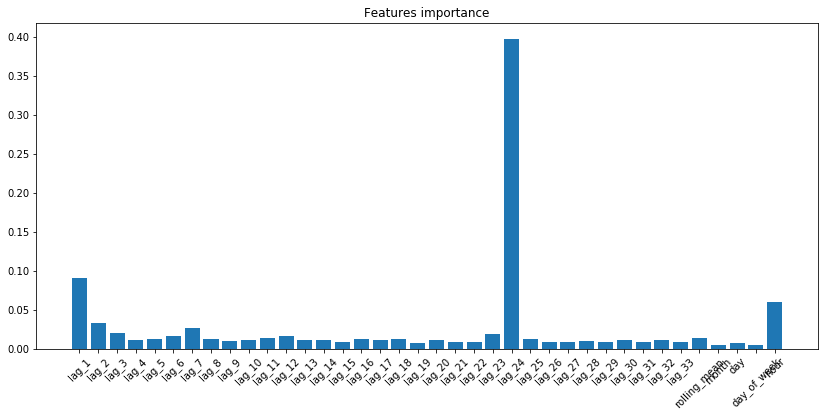

In [9]:
feat = model.feature_importances_
plt.figure(figsize=(14,6))
plt.bar(features.columns, feat)
plt.title('Features importance')
plt.xticks(rotation=45)
plt.show()

Самым важным в модели оказался 24 lag. Интересный факт, то есть модель в своей оценке опирается на то что было вчера примерно в это же время, т.к. в сутках 24 часа.

In [10]:
best = float('inf')
for depth in range(3,8,2):
    for regularization in (1, 0.1, 0.01, 0.001):
        train_pool = Pool(features_train, 
                  target_train, 
                  cat_features=[34,35,36,37])
        test_pool = Pool(features_valid, 
                 cat_features=[34,35,36,37]) 
        param = {
            'random_seed': 12345,
            'l2_leaf_reg': regularization,
            'n_estimators':30,
            'max_depth': depth, 
            'learning_rate': 0.1, 
            'loss_function': 'RMSE',
            'verbose': False,
        }
        cat_boost_model = CatBoostRegressor(**param)
        #train the cat_boost_model
        cat_boost_model.fit(train_pool)
        # make the prediction using the resulting cat_boost_model
        train_pool = Pool(features_train, cat_features=[34,35,36,37])
        predicted_tr = cat_boost_model.predict(train_pool)
        rmse_tr = mean_squared_error(target_train, predicted_tr) ** 0.5

        predicted_val = cat_boost_model.predict(test_pool)
        rmse_val = mean_squared_error(target_valid, predicted_val) ** 0.5
        if rmse_val < best:
            best = rmse_val
            print(f'depth = {depth}, regularization = {regularization}'.center(90,'-'))
            print(f'rmse on train data is - {rmse_tr:.3f}')
            print(f'rmse on validation data is - {rmse_val:.3f}')


------------------------------depth = 3, regularization = 1-------------------------------
rmse on train data is - 22.684
rmse on validation data is - 38.366
-----------------------------depth = 3, regularization = 0.1------------------------------
rmse on train data is - 22.640
rmse on validation data is - 38.125
-----------------------------depth = 3, regularization = 0.01-----------------------------
rmse on train data is - 22.639
rmse on validation data is - 38.120
------------------------------depth = 5, regularization = 1-------------------------------
rmse on train data is - 21.780
rmse on validation data is - 35.882
-----------------------------depth = 5, regularization = 0.1------------------------------
rmse on train data is - 21.749
rmse on validation data is - 35.813
----------------------------depth = 5, regularization = 0.001-----------------------------
rmse on train data is - 21.738
rmse on validation data is - 35.797


In [11]:
features_train = pd.concat([features_train, features_valid])
target_train =  pd.concat([target_train, target_valid])

train_pool = Pool(features_train, 
                  target_train, 
                  cat_features=[34,35,36,37])
param = {
    'random_seed': 12345,
    'n_estimators':200,
    'max_depth': 5, 
    'learning_rate': 0.1, 
    'loss_function': 'RMSE',
    'verbose': 50,
    'l2_leaf_reg': 0.001
}
cat_boost_model = CatBoostRegressor(**param)
cat_boost_model.fit(train_pool)
train_pool = Pool(features_train, cat_features=[34,35,36,37])
predicted_tr = cat_boost_model.predict(train_pool)
rmse_tr = mean_squared_error(target_train, predicted_tr) ** 0.5
print(f'rmse on train data is - {rmse_tr:.3f}')


0:	learn: 36.9388902	total: 9.71ms	remaining: 1.93s
50:	learn: 20.9303243	total: 2.88s	remaining: 8.41s
100:	learn: 19.2428491	total: 5.65s	remaining: 5.54s
150:	learn: 17.9053938	total: 8.63s	remaining: 2.8s
199:	learn: 16.7677536	total: 11.5s	remaining: 0us
rmse on train data is - 16.320


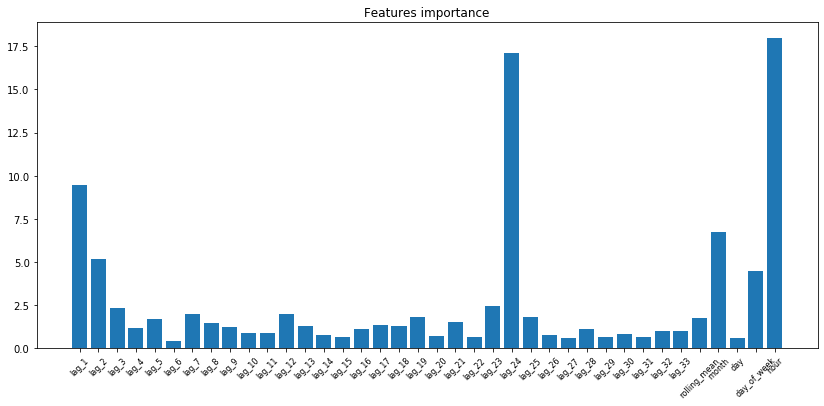

In [12]:
feat = cat_boost_model.get_feature_importance()
plt.figure(figsize=(14,6))
plt.bar(features.columns, feat)
plt.title('Features importance')
plt.xticks(rotation=45, fontsize=8)
plt.show()

##  Вывод
Лучшего результата удалось добиться на модели Cat Boost. Важные парметры примерно такие же как и случайного леса.

rmse по ней равен примерно 16, но это на тренировочных данных.

Осталось проверить модель на тестовых данных.

# 4. Тестирование

In [14]:
mean = data['num_orders'].mean()
predicted = [mean] * target_test.shape[0]
rmse_mean = mean_squared_error(target_test, predicted) ** 0.5
print(f'rmse on mean data is - {rmse_mean:.3f}')

predicted = model.predict(features_test)
rmse = mean_squared_error(target_test, predicted) ** 0.5
print(f'Forrest rmse on test data is  - {rmse:.3f}')

test_pool = Pool(features_test, 
         cat_features=[34,35,36,37]) 
predicted = cat_boost_model.predict(test_pool)
rmse_model = mean_squared_error(target_test, predicted) ** 0.5
print(f'Catboost rmse on test data is - {rmse_model:.3f}')

print(f'Catboost мolel rmse {rmse_mean / rmse_model :.2%} better than mean.')

rmse on mean data is - 80.374
Forrest rmse on test data is  - 51.177
Catboost rmse on test data is - 40.200
Catboost мolel rmse 199.94% better than mean.


# Общий вывод

Мы построили модель, которая работает с rmse 40 что и было нашей изначальной целью. 
Самым важным в достижении цели было правильно подобрать признаки для нашей модели, в нашем случае хорошо что мы добавили столбец "час", который имеет самый большой вес в предсказании нашей модели. 

Так же выжным оказалось преобразование нашего нестационарного ряда в стационарный.

Если сравнить нашу модель со средним значением, то модель предсказывает точнее почти на 200%, что выглядит как неплохой результат.

-----